In [2]:
import wandb
from condgen.models.score_matching import ConditionalScoreMatcher
from condgen.data_utils.data_utils_MNIST import MNISTDataModule
from condgen.data_utils.data_utils_cf_traj import SimpleTrajDataModule
from condgen.models import samplers
import pytorch_lightning as pl
import torch
import numpy as np
import os

from torchvision.utils import make_grid
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tqdm 
import pandas as pd
import torchvision
from condgen.models.CFGAN import CFGAN
from condgen.models.baselines_cf import CFBaseline
import torchvision.transforms as transforms
from PIL import Image

/home/edward/.cache/pypoetry/virtualenvs/condgen-8jXrSjT1-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
api = wandb.Api()

def diffusion_sample(img_x, img_y, color, T, sample_batch_size = 50, run_name = f"edebrouwer/dmm/3t5r2hao", degrees = [0, 10, 20, 30, 40]):

    gpu = 0

    run = api.run(run_name)

    model_cls = ConditionalScoreMatcher
    dataset_cls = MNISTDataModule


    fname = [f.name for f in run.files() if "ckpt" in f.name][0]
    run.file(fname).download(replace = True, root = ".")
    model = model_cls.load_from_checkpoint(fname, input_dim = 1, output_dim = 3, conditional_len = 28, one_D = False)
    os.remove(fname)

    hparams = dict(model.hparams)
    dataset = dataset_cls(**hparams)
    dataset.prepare_data()

    device = torch.device("cuda:0")
    model = model.to(device)

    #img_x, img_y,_, color, T = next(iter(dataset.test_dataloader()))

    sampler = samplers.ode_sampler
    z_samples = model.abduct(sampler, sample_batch_size, X_cond = img_x[:sample_batch_size].to(device), T_cond = T[:sample_batch_size].to(device), X_obs = img_y[:sample_batch_size].to(device))


    imgs_list = [img_y]
    for degree in degrees:
        T_new = torch.ones(T.shape)*degree
        cf_samples = model.sample(sampler, sample_batch_size, X_cond = img_x[:sample_batch_size].to(device), T_cond = T_new[:sample_batch_size].to(device),z = z_samples).cpu().detach()
        imgs_list.append(cf_samples)
    
    return imgs_list

def CFGAN_sample(run = api.run(f"edebrouwer/counterfactuals/qd27oe88"),degrees = [0, 10, 20, 30, 40]):
    gpu = 0

    model_cls = CFGAN
    dataset_cls = MNISTDataModule

    fname = [f.name for f in run.files() if (("ckpt" in f.name) and ("stage2"in f.name))][0]
    run.file(fname).download(replace = True, root = ".")
    model = model_cls.load_from_checkpoint(fname,num_classes_model = -1)
    os.remove(fname)

    hparams = dict(model.hparams)
    dataset = dataset_cls(**hparams)
    dataset.prepare_data()

    device = torch.device("cuda:0")
    model = model.to(device)

    img_x, img_y,_, color, T  = next(iter(dataset.test_dataloader()))

    #img_rec = model.counterfactual_pred(img_x.to(device),img_y.to(device),T.to(device), T.to(device))[0].cpu().detach()

    imgs_list = [img_y]
    for degree in degrees:
        T_new = torch.ones(T.shape)*degree
        img_new = model.counterfactual_pred(img_x.to(device),img_y.to(device),T.to(device), T_new.to(device),color = None)[0].cpu().detach()
        imgs_list.append(img_new)
        
    return imgs_list, img_x, img_y, color, T

def CFGAN_baseline_sample(img_x, img_y, color, T, run = api.run(f"edebrouwer/counterfactuals/z3s996k9"),degrees = [0, 10, 20, 30, 40]):
    gpu = 0

    model_cls = CFBaseline
    dataset_cls = MNISTDataModule

    fname = [f.name for f in run.files() if (("ckpt" in f.name))][0]
    run.file(fname).download(replace = True, root = ".")
    model = model_cls.load_from_checkpoint(fname,num_classes_model = -1)
    os.remove(fname)

    hparams = dict(model.hparams)
    dataset = dataset_cls(**hparams)
    dataset.prepare_data()

    device = torch.device("cuda:0")
    model = model.to(device)

    #img_rec = model.counterfactual_pred(img_x.to(device),img_y.to(device),T.to(device), T.to(device))[0].cpu().detach()

    imgs_list = [img_y]
    for degree in degrees:
        T_new = torch.ones(T.shape)*degree
        img_new = model.counterfactual_pred(img_x.to(device),img_y.to(device),T.to(device), T_new.to(device))[0].cpu().detach()
        imgs_list.append(img_new)
        
    return imgs_list

def get_cf(img_y,T, degrees = [0, 10, 20, 30, 40]):
    totensor = transforms.PILToTensor()
    imgs_cf = [img_y]
    for degree in degrees:
        imgs_list = []
        for idx in range(len(img_y)):
            img = Image.fromarray((img_y[idx].permute(1,2,0).numpy()* 255).astype(np.uint8))
            img_cf = totensor(transforms.functional.rotate(img, angle = degree - T[idx].item())).float()/255
            imgs_list.append(img_cf)
        imgs_cf.append(imgs_list)
    return imgs_cf

In [12]:
imgs_list, img_x, img_y, color, T = CFGAN_sample()
imgs_list_baseline = CFGAN_baseline_sample(img_x, img_y, color, T)

In [13]:
diffusion_imgs_list = diffusion_sample(img_x, img_y, color, T)

Number of function evaluations: 338
Number of function evaluations: 314
Number of function evaluations: 314
Number of function evaluations: 308
Number of function evaluations: 320
Number of function evaluations: 308


In [14]:
imgs_list_true = get_cf(img_y,T)

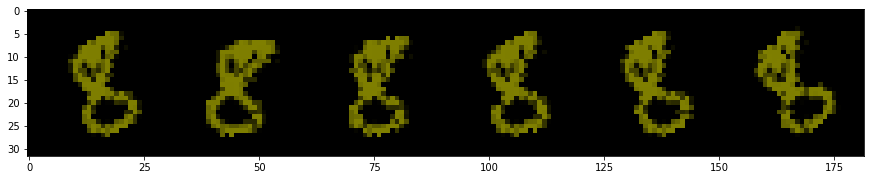

In [15]:
#True CF
idxs = [13]

sequence_imgs = [torch.stack([im_new[idx] for im_new in imgs_list_true]) for idx in idxs]
grid_img = [torchvision.utils.make_grid(seq_img, nrow=len(imgs_list_true)) for seq_img in sequence_imgs]

true_grid_img = torch.cat(grid_img,1)
plt.figure(figsize=(15,15))
plt.imshow(true_grid_img.permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


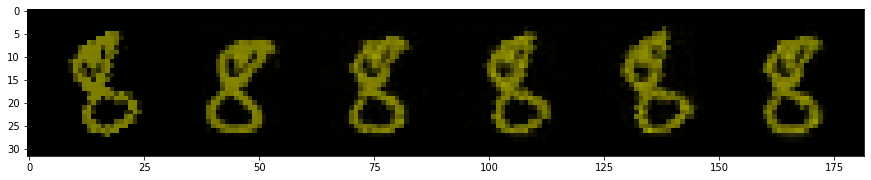

In [16]:
#CFGAN
idxs = [13]

sequence_imgs = [torch.stack([im_new[idx] for im_new in imgs_list]) for idx in idxs]
grid_img = [torchvision.utils.make_grid(seq_img, nrow=len(imgs_list)) for seq_img in sequence_imgs]

cfgan_grid_img = torch.cat(grid_img,1)
plt.figure(figsize=(15,15))
plt.imshow(cfgan_grid_img.permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


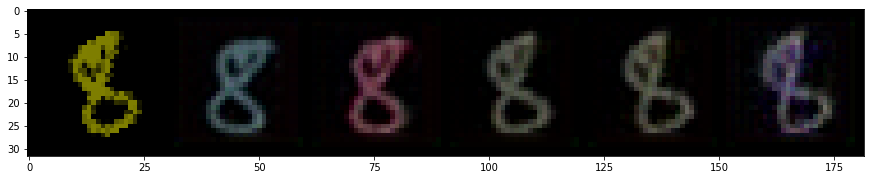

In [17]:
#Baseline
idxs = [13]

sequence_imgs = [torch.stack([im_new[idx] for im_new in imgs_list_baseline]) for idx in idxs]
grid_img = [torchvision.utils.make_grid(seq_img, nrow=len(imgs_list_baseline)) for seq_img in sequence_imgs]

baseline_grid_img = torch.cat(grid_img,1)
plt.figure(figsize=(15,15))
plt.imshow(baseline_grid_img.permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


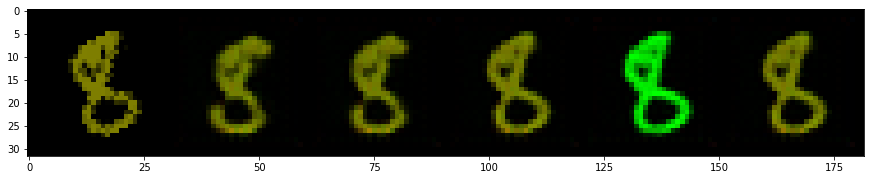

In [18]:
#Diffusion
idxs = [13]

sequence_imgs = [torch.stack([im_new[idx] for im_new in diffusion_imgs_list]) for idx in idxs]
grid_img = [torchvision.utils.make_grid(seq_img, nrow=len(diffusion_imgs_list)) for seq_img in sequence_imgs]

diffusion_grid_img = torch.cat(grid_img,1)
plt.figure(figsize=(15,15))
plt.imshow(diffusion_grid_img.permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


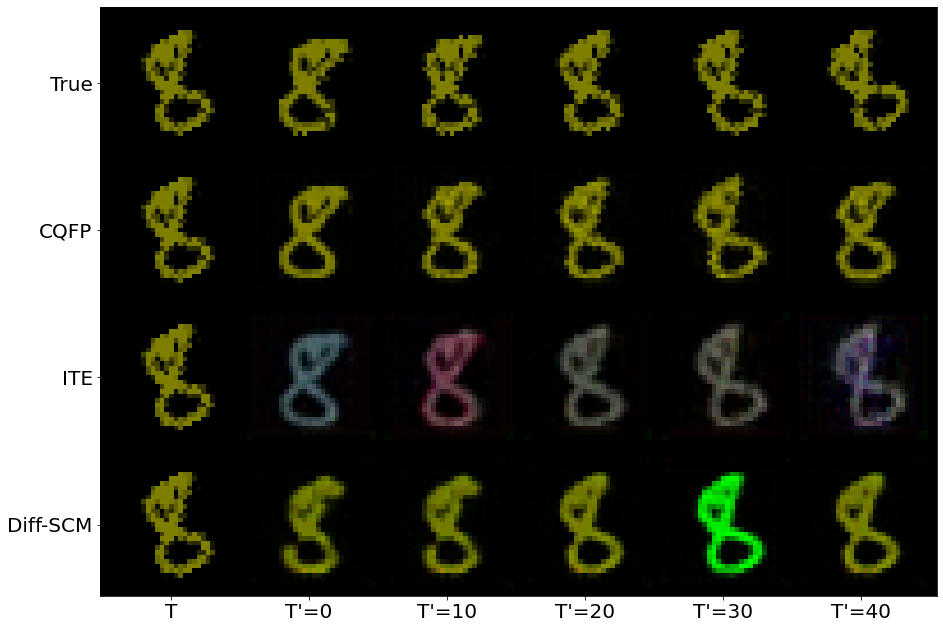

In [19]:
full_grid = torch.cat((true_grid_img,cfgan_grid_img,baseline_grid_img,diffusion_grid_img),1)

fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.imshow(full_grid.permute(1, 2, 0))
x_label_list = ['T', 'T\'=0', 'T\'=10', 'T\'=20','T\'=30',"T\'=40"]
ax.set_xticks([15,45,75,105,135,165])
ax.set_xticklabels(x_label_list,fontsize=20)

y_label_list = ['True', 'CQFP', 'ITE', 'Diff-SCM']
ax.set_yticks([16,48,80,112])
ax.set_yticklabels(y_label_list,fontsize=20)
plt.savefig("figs/MNIST_examples.pdf")
plt.show()